In [1]:
import cft

from numpy import random, fft, linalg, pi
import numpy as np
from IPython.display import display, Image, HTML
from gnuplot import plot, plot_three, plot_six, plot_pdf, Multiplot

N = 256
L = 22
B = cft.Box(2, N, L)

# Introducing Constrained Fields

Constrained Gaussian Random fields can be as easy as pie. What do we know about GRFs? We have a one-point function of

$$\mathcal{P}(f_1) = \frac{1}{\sqrt{\tau v}} \exp \left[-\frac{f_1}{2v}\right]$$

and an $N$-point function of

$$\mathcal{P}(f) = \frac{1}{\sqrt{\tau^N \det M}} \exp\left[-\frac{1}{2}f^{\dagger}M^{-1}f\right],$$

where $f$ is now an $N$-vector of values, and $M$ the $(N \times N)$-covariance-matrix,

$$M_{ij} = \langle f_i^*f_j\rangle.$$

In the case of Gaussian random fields, all the $N$-point functions can be described in terms of the two-point function, and we can write the covariance matrix as

$$M_{(2)} = \begin{pmatrix} v & \xi \\ \xi & v \end{pmatrix},$$

where $\xi$ is the _two-point correlation function_. In the paper by _van de Weygaert & Bertschinger (1996)_ (WB96), the $N$-point function is written in a functional form. We will be focussing on the computation of CGRFs, we will keep the matrix the notation for finite $N$. Computing the expectation value of a quantity $A(f)$,

$$\langle A\rangle = \int A(f) \mathcal{P}(f) {\rm d}^N f,$$
assuming $\mathcal{P}(f)$ is properly normalised.

To show the difference between an uncorrelated and correlated random field, I have created three instances of a GRF below with _power spectrum_ of $P(k) = k^{n}$, where $n = 0, -1, -2$. The value in each cell is an element in the vector $f$.

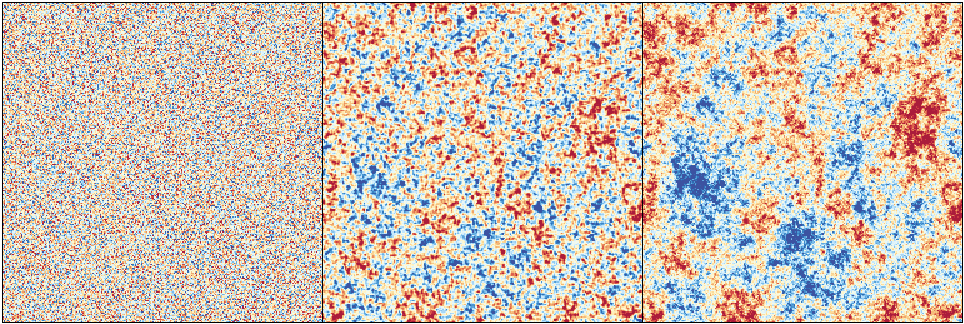

In [2]:
def garfield(B, wn, P):
    f = fft.ifftn(fft.fftn(wn) * np.sqrt(P(B.K))).real
    f /= f.std()
    return f

P0 = cft.Power_law(2)
P1 = cft.Power_law(-1) * cft.Scale(B, 0.1)
P2 = cft.Power_law(-2)

random.seed(17)
wn = random.normal(0, 1, [N, N])
plot_three(B, wn, garfield(B, wn, P1), garfield(B, wn, P2))

## Constraints
We will influence the generating of a random field by imposing constraints. For example, we might want a density peak in the center of our box, then we can encode this wish in a series of constraints: scaled with a certain gaussian filter the gradient is zero, and the density has some positive value, while the second derivatives are all negative. The field is then subject to a set of $M$ constraints such that,

$$\Gamma = \left\{ C_i(f) = g_i ; i = 1, \dots, M \right\}.$$

For practical purposes we have to make sure that each costraint function $C_i$ is linear in the sense that it can be expressed in terms of a linear combination of all elements in $f,$

$$C_i(f) = \langle\mathcal{C}_i, f\rangle,$$

or if you will, there is a matrix $N \times M$ matrix $C$ that transforms $f$, to the set of constraint values $g$.

In particular the case where the constraint can be expressed as a convolution is common

$$C_i(f, x) = \frac{1}{N}\sum_i g(x - y_i) f(y_i).$$

The problem is how to sample the possible constraint realisations properly,

$$\mathcal{P}\big(f|\Gamma\big) = \frac{\mathcal{P}\big(f \cap \Gamma\big)}{\mathcal{P}
\big(\Gamma\big)} = \frac{\mathcal{P}\big(f\big)}{\mathcal{P}\big(\Gamma\big)}.$$

Since the coefficients $c_i$ are linear combinations of Gaussian variables, they are themselves distributed as a multivariate Gaussian with the covariance matrix
$Q_{ij} = \langle g_i^* g_j\rangle = CMC^{\dagger},$ (how do we show this last equality? $(AB)^{-1} = B^{-1}A^{-1}$ then substitute in $N$-point distribution)

$$\mathcal{P}\big(\Gamma\big) = \frac{1}{\sqrt{\tau^M \det Q}} \exp\left[-\frac{1}{2}g^{\dagger}Q^{-1}g\right].$$

$$\mathcal{P}\big(f|\Gamma\big) = \sqrt{\frac{\tau^M \det Q}{\tau^N \det M}} \exp\left[-\frac{1}{2}\left(f^{\dagger}M^{-1}f - g^{\dagger}Q^{-1}g\right)\right]$$

The term in the exponential can be written in the form $1/2F^{\dagger} M^{-1} F$,
where $F = f - \bar{f}$. Defining $\bar{f}$, the mean field under the constraints as

$$\bar{f} := MC^{\dagger}Q^{-1}g = \big\langle f | \Gamma \big\rangle.$$

The combination $MC^{\dagger}$ equals the cross-correlation between the random field and
the set of constraints $\langle f C_i(f)\rangle$.
If we were to substitute $C^{-\dagger}M^{-1}C^{-1}$ into this definition, we would get
the expression $C^{-1} g$, but $C$ is in general not invertible. According to _Bertschinger (1987)_ (B87), $f = \bar{f}$ is a stationary point of the action: $\delta S/\delta f = 0$ for $f = \bar{f}$. Where the _action_ $S$ is the term in the exponential of the distribution function. This computation is apparently explained in _Bardeen et al. (1986)_ (BBKS).

Moving back to WB96 and its appendix C, we now see that the constrained field is the sum of an average part $\bar{f}$ and a residual part $F$. The insight needed is that an unconstrained field $\tilde{f}$ will have non-zero constraint coefficients $\tilde{g} = C\tilde{f}$. Since everything is linear, all we need to do is add to the unconstrained field an average field with coefficients $g - \tilde{g}$. Suppose there are two sets of constraints $\Gamma_1$ and $\Gamma_2$, and we have a realisation $f_1$ with constraint coefficients $g_1 = C f_1$, then we can transform this realisation into $f_2$ with $g_2 = C f_2$
as follows

$$f_2 = f_1 - \bar{f}_1 + \bar{f}_2.$$

This implies that there is a bijection between the realisations of two sets of constraints. In other words, for each realisation $f$, drawn from the distribution
with constraints $\Gamma_1$, there is one with equal probability from $\Gamma_2$, or

$$\mathcal{P}\big(f_1 | \Gamma_1\big) = \mathcal{P}\big(f_2 | \Gamma_2\big).$$

This also means that the residual field $F$ is independent of the chosen constraint coefficients.

Computing the average field seems like a lot of work, since there is the matrix $M$ in the expression. However, if we do all our work in Fourier space, the different modes $\hat{f}(k)$ are independent, and $M$ is diagonal. Again, because the Fourier transformation is linear, we retain all nice properties that we just derived.

### Example: a peak in the center of the box
In the case of a peak in two dimensions there are six constraints: the height of the peak, the two first derivatives, and the three components of the Hessian; all fixed at some scale.

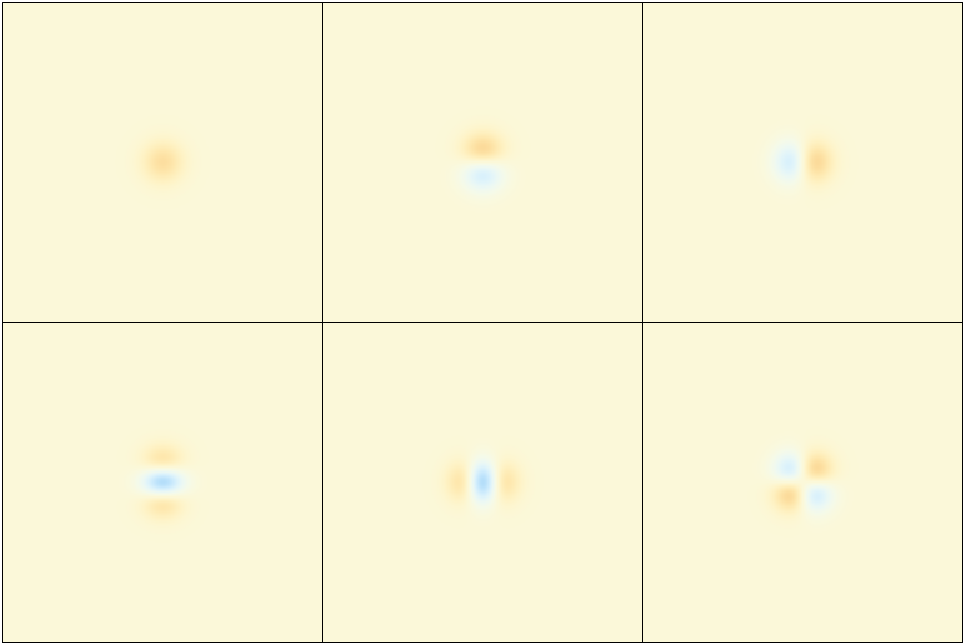

In [3]:
import gnuplot
import imp ; imp.reload(gnuplot)
sigma = 1.0
S = cft.Cutoff(B) * cft.Scale(B, sigma) * cft.Pos([L/2, L/2])
extra = [(a * S) / (a * S).abs(B, P1) for a in
         [cft.Potential() * cft.D(1), cft.Potential() * cft.D(2)]]
H = cft.make_peak(B, P1, S) + extra
gnuplot.plot_six(B, *[fft.ifftn(h(B.K)).real for h in H][:6])

Now we take a normal unconstrained field and compute the resulting coefficients.

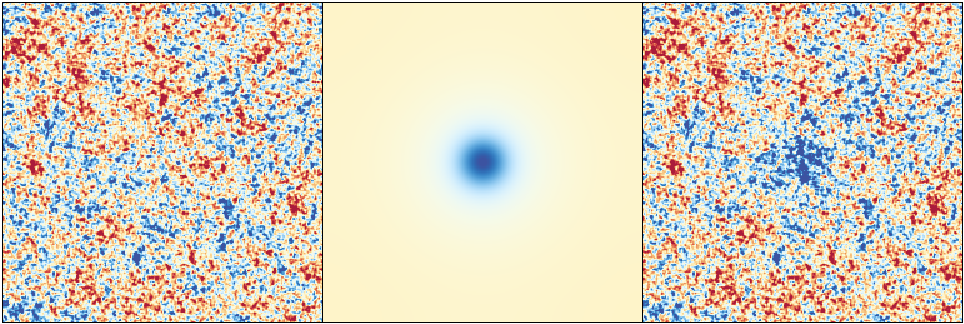

0.957631542037


In [4]:
cgrf = cft.CGRF(B, P1, H)
cgrf.generate_noise()
cgrf.set_coefficients(np.r_[1.0,0,0, -0.53, -0.53,0, 0, 0]*-4)
A1 = cgrf.triplet()
#cgrf.generate_noise(seed=53)
A2 = cgrf.triplet(cft.Potential())
plot_three(B, *A1)
print(cgrf.p_value(cgrf.g))

## Partial constraints
If we want to sample a distribution with constraints that are not completely fixed, we need to pull random deviates from the distribution of coefficients. In the case above,
of a single peak constraint. So lets explore its probability space.

In [8]:
from IPython.display import Latex

def format_matrix(M):
    s = "\\[\\left(\\begin{array}{" + "r"*M.shape[0] + "}\n    "
    s += " \\\\\n    ".join([" & ".join(["{0: >6,.2f}".format(q) for q in row]) for row in np.array(M)])
    s += "\n\\end{array}\\right)\\]\n"
    return Latex(s)

format_matrix(cgrf.Q)

<IPython.core.display.Latex object>

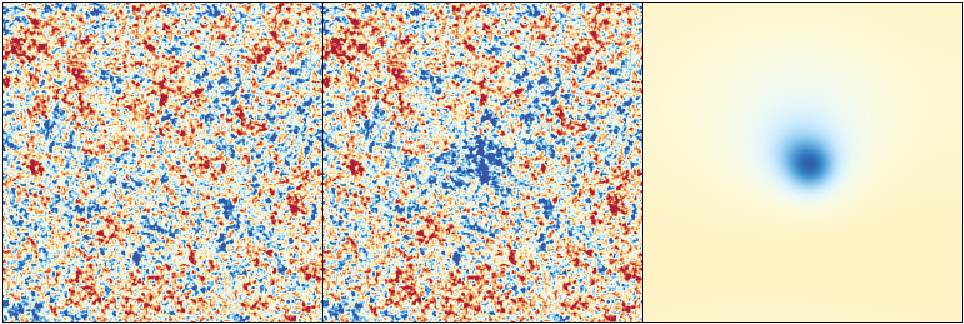

In [10]:
plot_three(B, A1[0], A1[2], A1[2] - A1[0])